In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

In [9]:
pairs = ["XRP","LINK","ADA","ETH","DOT","BTC","TRX","KAVA","AAVE","UNI",\
         "GRT","COMP","WAVES","KSM","YFI","ATOM","EOS","BAT","DOGE","DASH",\
         "ZEC","ETC","FIL","ALGO"]
        
long_pairs = ["XXRPZEUR","LINKEUR","ADAEUR","XETHZEUR","DOTEUR","XXBTZEUR",\
             "TRXEUR","KAVAEUR","AAVEEUR","UNIEUR","GRTEUR","COMPEUR","WAVESEUR",\
             "KSMEUR","YFIEUR","ATOMEUR","EOSEUR","BATEUR","XDGEUR","DASHEUR",\
              "XZECZEUR","XETCZEUR","FILEUR","ALGOEUR"]



dfs = []

for pair,long_pair in zip(pairs,long_pairs):

  response = requests.get(f"https://api.kraken.com/0/public/OHLC?pair={pair}EUR&since=0&interval=1440")
  response = response.json()["result"][long_pair]

  date = [item[0] for item in response]
  date = [datetime.utcfromtimestamp(item).strftime('%Y-%m-%d %H') for item in date]
  date = pd.to_datetime(date)

  close = [item[4] for item in response]

  df = pd.DataFrame(index = date, data=close, columns=["close"])
  df = df.astype(float)
  dfs.append(df)

In [11]:
df_main = pd.DataFrame(index=dfs[0].index)



for df in dfs:
  df_main = pd.concat([df_main,df], axis=1)

df_main.fillna(method="ffill",inplace=True)
df_main.fillna(method="bfill",inplace=True)

# **Trend-Following Strategy**

In [13]:
# Fast and slow moving averages

# Fast crosses slow from below = buy
# Fast crosses slow from above = sell
# between just holds.

In [14]:
# Assumptions & Restrictions

# No short-selling (hold stock or hold cash)

In [25]:
xrp = dfs[0].copy()
xrp["LogReturn"] = np.log(xrp["close"]).diff()
xrp["LogReturn"] = xrp["LogReturn"].shift(-1)

xrp["SlowSMA"] = xrp["close"].rolling(30).mean()
xrp["FastSMA"] = xrp["close"].rolling(10).mean()
xrp["Signal"] = np.where(xrp["FastSMA"] >= xrp["SlowSMA"], 1, 0)

xrp["PrevSignal"] = xrp["Signal"].shift(1)
xrp["Buy"] = (xrp["PrevSignal"] == 0) & (xrp["Signal"] == 1)
xrp["Sell"] = (xrp["PrevSignal"] == 1) & (xrp["Signal"] == 0)

In [26]:
is_invested = False
def assign_is_invested(row):
  global is_invested 
  if is_invested and row["Sell"]:
    is_invested = False
  if not is_invested and row["Buy"]:
    is_invested = True
  
  return is_invested

In [27]:
xrp["IsInvested"] = xrp.apply(assign_is_invested, axis=1)

xrp["AlgoLogReturn"] = xrp["IsInvested"] * xrp["LogReturn"]

In [28]:
print("Total algo log return (buy-sell):", xrp["AlgoLogReturn"].sum())
print("Total return (buy-hold):",xrp["LogReturn"].sum())

Total algo log return (buy-sell): 0.9588422828946104
Total return (buy-hold): 0.4883936611196953


In [36]:
print("Standard deviation (buy-sell):", xrp["AlgoLogReturn"].std())
print("Sharp ratio (buy-sell):", xrp["AlgoLogReturn"].mean()/xrp["AlgoLogReturn"].std())

print("Standard deviation (buy-hold):", xrp["LogReturn"].std())
print("Sharp ratio buy (buy-hold):", xrp["LogReturn"].mean()/xrp["LogReturn"].std())

Standard deviation (buy-sell): 0.03763782309461655
Sharp ratio (buy-sell): 0.05697609433588513
Standard deviation (buy-hold): 0.0577007767044647
Sharp ratio buy (buy-hold): 0.011772249800555579


# **Seach for fast and slow hyperparameters**

In [30]:
Ntest = 144
def trend_following(df, fast, slow):
  global is_invested
  df["SlowSMA"] = df["close"].rolling(slow).mean()
  df["FastSMA"] = df["close"].rolling(fast).mean()
  df["Signal"] =  np.where(df["FastSMA"]  >= df["SlowSMA"], 1, 0)
  df["PrevSignal"] = df["Signal"].shift(1)
  df["Buy"] = (df["PrevSignal"] == 0) & (df["Signal"] == 1)
  df["Sell"] = (df["PrevSignal"] == 1) & (df["Signal"] == 0)

  train = df.iloc[:-Ntest]
  test = df.iloc[-Ntest:]

  is_invested = False
  df.loc[:-Ntest, "IsInvested"] = train.apply(assign_is_invested, axis=1)
  df.loc[:-Ntest, "AlgoLogReturn"] = train["IsInvested"] * train["LogReturn"]

  is_invested = False
  df.loc[-Ntest:, "IsInvested"] = test.apply(assign_is_invested, axis=1)
  df.loc[-Ntest:, "AlgoLogReturn"] = test["IsInvested"] * test["LogReturn"]

  return train["AlgoLogReturn"][:-1].sum(), test["AlgoLogReturn"][:-1].sum()

In [31]:
trend_following(xrp,10,30)

(0.03442707462445571, 0.9244152082701547)

In [35]:
best_fast = None
best_slow = None
best_score = float("-inf")

for fast in range(3,30):
  for slow in range(fast + 5, 50):
    score, _ = trend_following(xrp,fast,slow)
    if score > best_score:
      best_fast = fast
      best_slow = slow
      best_score = score
best_fast, best_slow, trend_following(xrp,best_fast,best_slow)

(3, 21, (0.805160946364545, 0.7531773860922324))

# **Analysing Train/test**

In [37]:
train = xrp.iloc[:-Ntest].copy()
test = xrp.iloc[-Ntest:].copy()

In [39]:
# Total returns buy and hold in train/test

print(train["LogReturn"][:-1].sum())
print(test["LogReturn"][:-1].sum())

-0.2981003406098899
0.8029683556955143


In [44]:
# Sharp ratio algo vs buy-hold Train

train["AlgoLogReturn"].mean()/train["AlgoLogReturn"].std(), train["LogReturn"].mean()/train["LogReturn"].std()

(0.0484140083775595, -0.012936710652816374)

In [45]:
# Sharp ratio algo vs buy-hold Test

test["AlgoLogReturn"].mean()/test["AlgoLogReturn"].std(), test["LogReturn"].mean()/test["LogReturn"].std()

(0.08421338130732528, 0.057347722611249215)

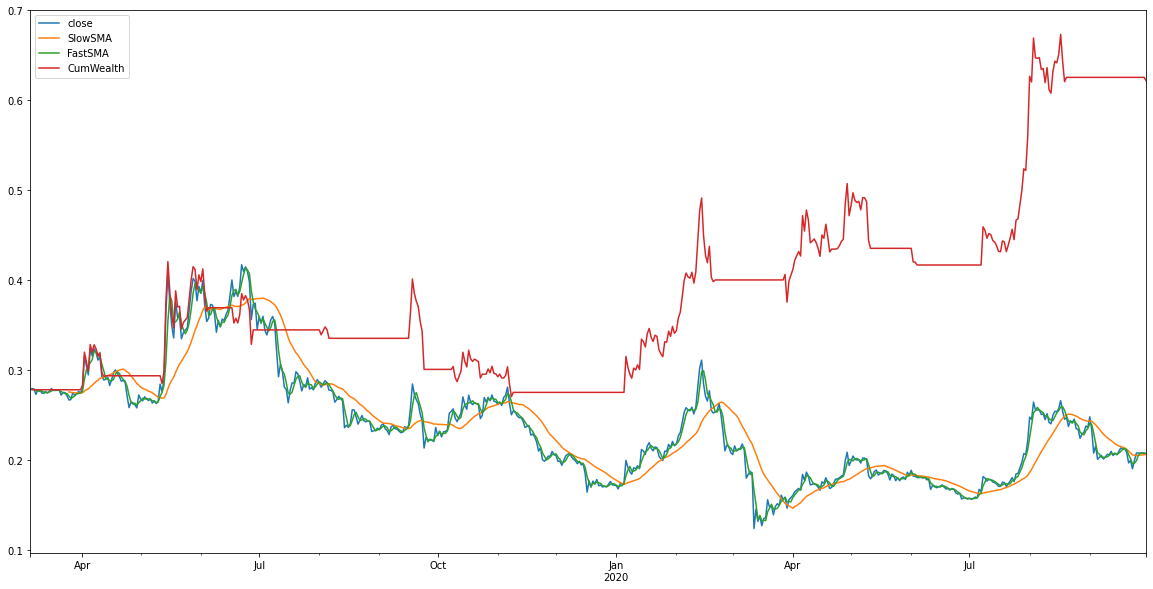

In [49]:
train["CumLogReturn"] = train["AlgoLogReturn"].cumsum().shift(1)
train["CumWealth"] = train.iloc[0]["close"] * np.exp(train["CumLogReturn"])
train[["close", "SlowSMA","FastSMA","CumWealth"]].plot(figsize=(20,10))